In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, results as rs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

In [4]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=2286220245024) was called 1 times


2021-01-06 18:12:16,796 - NumExpr defaulting to 8 threads.


In [5]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=2286220245888) was called 1 times


In [6]:
fa,unmapped, end_time = feat.preprocess_faults(scs_raw)
fa= fa[fa['timestamp']<(fa['timestamp'].max()-pd.to_timedelta(7, unit='D'))]


Running: Function "preprocess_faults" (id=2286220244880) was called 1 times
Running: Function "load_tote_lookup" (id=2286220246608) was called 1 times
Running: Function "load_module_lookup" (id=2286217472896) was called 1 times
Running: Function "load_ID_lookup" (id=2286220243296) was called 1 times
duplicated location faults removed - max duration kept
HOTFIX: Quadrant only faults, PTT Asset Code update


In [7]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa_floor['Duration'][i] = fa_floor['Time Left'][i]
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa_floor['Duration'][i+1] = fa_floor['Duration'][i+1] - fa_floor['Duration'][i]
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [8]:
df,fa_PTT = feat.create_PTT_df(fa_floor,at,av)

df = feat.log_totes(df) 

Running: Function "load_PTT_lookup" (id=2286220245312) was called 1 times
Running: Function "aggregate_availability" (id=2286220244736) was called 1 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 2 times
Running: Function "aggregate_availability" (id=2286220244736) was called 2 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 3 times
Running: Function "aggregate_availability" (id=2286220244736) was called 3 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 4 times
Running: Function "aggregate_availability" (id=2286220244736) was called 4 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 5 times
Running: Function "aggregate_availability" (id=2286220244736) was called 5 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 6 times
Running: Function "aggregate_availability" (id=2286220244736) was called 6 times
Running: Function "load_PTT_lookup" (id=2286220245312) was called 7 ti

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:708: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_totes'] = np.log(df['TOTES'])


In [9]:
df_week = df[df['timestamp']>end_time - pd.to_timedelta(14, unit='D')]

In [10]:
X,y = md.gen_feat_var(df_week,target = 'Availability', features = ['Faults','Totes'])


In [11]:
X_train, X_test, y_train, y_test = md.split(X,y,split_options = {'test_size': 0.3,
                                                                 'random_state': None})

R2_cv,R2_OOS,Coeff = md.run_OLS(X_train = X_train,y_train = y_train,X_test = X_test,y_test=y_test, n = 30)

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Cross Validation Scores: 
 
        R2 Scores
1       0.437578
2       0.435915
3       0.449870
4       0.469710
5      -0.309386
Mean    0.296738
STD     0.303302
273
                                 OLS Regression Results                                
Dep. Variable:           Availability   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              489.9
Date:                Wed, 06 Jan 2021   Prob (F-statistic):                        0.00
Time:                        18:13:49   Log-Likelihood:                          2761.1
No. Observations:                4256   AIC:                                     -5086.
Df Residuals:                    4038   BIC:                                     -3701.
Df Model:                         218                                                  
Covariance Type:            nonrobust 

C:\Users\Jamie.williams\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [12]:
R2_OOS

0.31204181000363607

In [13]:
Output = rs.create_output(fa_PTT,Coeff,end_time-pd.to_timedelta(7, unit='D'))

# Plotting

In [14]:
Output['Total'] = Output[:][Output.columns[8:]].sum(axis=1)

In [15]:
Total = Output[['Asset Code','Total']].groupby('Asset Code').sum().reset_index()

In [16]:
Output[Output['Asset Code'].str.contains('C23')]

,Alert ID,Alert,Fault ID,Asset Code,Tote Colour,Quadrant,MODULE,Original_timestamp,PTT011,PTT012,...,PTT152,PTT171,PTT172,PTT181,PTT182,PTT191,PTT192,PTT201,PTT202,Total
3651,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 12:05:05,51.744968,51.744968,...,51.744968,51.744968,51.744968,51.744968,51.744968,51.744968,51.744968,51.744968,51.744968,1862.818857
3652,107576.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 12:00:00,4.648410,4.648410,...,4.648410,4.648410,4.648410,4.648410,4.648410,4.648410,4.648410,4.648410,4.648410,167.342756
3653,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 13:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738
3654,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 14:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738
3655,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 15:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738
3656,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 16:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738
3657,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 17:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738
3658,106049.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 18:00:00,30.717195,30.717195,...,30.717195,30.717195,30.717195,30.717195,30.717195,30.717195,30.717195,30.717195,30.717195,1105.819024
3659,103495.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 18:32:46,25.660479,25.660479,...,25.660479,25.660479,25.660479,25.660479,25.660479,25.660479,25.660479,25.660479,25.660479,923.777242
3660,103495.0,C23: C2303BCL151 151B54 sensor fault,3428.0,C2303BCL151,Blue,0.0,0,2020-12-02 19:00:00,56.534715,56.534715,...,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,56.534715,2035.249738


In [17]:
Output

,Alert ID,Alert,Fault ID,Asset Code,Tote Colour,Quadrant,MODULE,Original_timestamp,PTT011,PTT012,...,PTT152,PTT171,PTT172,PTT181,PTT182,PTT191,PTT192,PTT201,PTT202,Total
14,105734.0,C05: C0502STA030 030B12 occupancy sensor fault,3416.0,C0502STA030,Blue,1.0,1,2020-12-02 12:37:29,2.197172,2.197172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.394343
100,103695.0,C07: C0703STA102 102B13 occupancy sensor fault,3416.0,C0703STA102,Blue,1.0,0,2020-12-02 17:49:30,26.844431,26.844431,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,268.444310
106,103721.0,C05: C0501STA020 020B12 occupancy sensor fault,3416.0,C0501STA020,Grey,1.0,0,2020-12-02 17:43:38,19.089272,19.089272,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,190.892720
107,103721.0,C05: C0501STA020 020B12 occupancy sensor fault,3416.0,C0501STA020,Grey,1.0,0,2020-12-02 18:00:00,33.104919,33.104919,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,331.049188
3226,106055.0,C16: C1603STA253 253B11 occupancy sensor fault,3416.0,C1603STA253,Blue,0.0,0,2020-12-02 12:04:09,1.075531,1.075531,...,1.075531,1.075531,1.075531,1.075531,1.075531,1.075531,1.075531,1.075531,1.075531,38.719101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16766,103821.0,C14: C14PTT192_ external unit fault,3611.0,C14PTT192,Both,4.0,19,2020-12-02 17:23:38,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.705746,0.000000,0.000000,2.705746
16767,103505.0,C14: C14PTT192_ external unit fault,3611.0,C14PTT192,Both,4.0,19,2020-12-02 18:29:55,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.246895,0.000000,0.000000,3.246895
16768,103374.0,C14: C14PTT192_ external unit fault,3611.0,C14PTT192,Both,4.0,19,2020-12-02 19:03:53,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.705746,0.000000,0.000000,2.705746
16769,102197.0,C14: C14PTT192_ external unit fault,3611.0,C14PTT192,Both,4.0,19,2020-12-02 22:41:18,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.246895,0.000000,0.000000,3.246895


Text(0.5, 1.0, 'SCS Lost Singles Last 12 Hours')

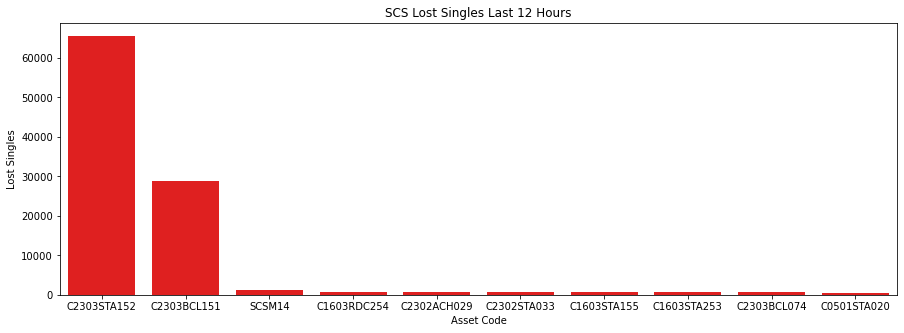

In [18]:
plt.figure(figsize=(15,5))
sns.barplot(y='Total',x = 'Asset Code',data = Total.sort_values(by='Total',ascending=False).head(10),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [19]:
PTT081 = Output[['Asset Code','PTT081']].groupby('Asset Code').sum().reset_index()

Text(0.5, 1.0, 'PTT081 Lost Singles Last 12 Hours')

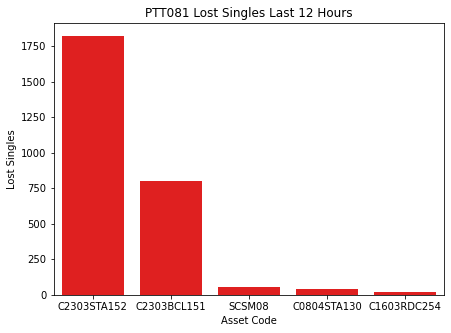

In [20]:
plt.figure(figsize=(7,5))
sns.barplot(y='PTT081',x = 'Asset Code',data = PTT081.sort_values(by='PTT081',ascending=False).head(5),color = 'r')
plt.ylabel('Lost Singles')
plt.title('PTT081 Lost Singles Last 12 Hours')

In [21]:
Total_colour = Output[['Tote Colour','Total']].groupby('Tote Colour').sum().reset_index()

Text(0.5, 1.0, 'SCS Lost Singles Last 12 Hours')

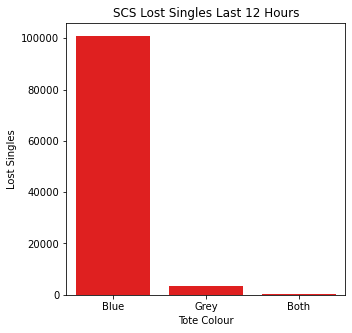

In [22]:
plt.figure(figsize=(5,5))
sns.barplot(y='Total',x = 'Tote Colour',data = Total_colour.sort_values(by='Total',ascending=False),color = 'r')
plt.ylabel('Lost Singles')
plt.title('SCS Lost Singles Last 12 Hours')

In [23]:
Total_colour

,Tote Colour,Total
0,Blue,100891.540946
1,Both,492.118821
2,Grey,3240.229883


(0.0, 5.0)

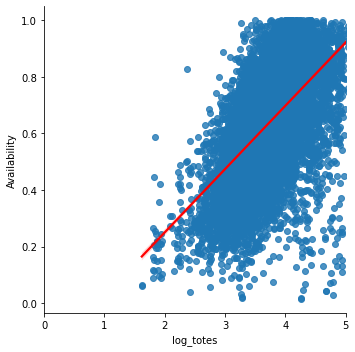

In [24]:
sns.lmplot(x='log_totes', y='Availability', data=df, line_kws={"color": "red"})
plt.xlim(0, 5)

In [25]:
df.shape

(11169, 1027)

In [26]:
sns.lmplot(x='TOTES', y='Availability', data=df_week, line_kws={"color": "red"})

KeyError: "['TOTES'] not in index"

In [ ]:
ax = sns.regplot(x="TOTES", y="Availability", data=df_week,
x_estimator=np.mean, logx=True, line_kws={"color": "red"})
plt.ylim(0,1)

In [ ]:
sns.lmplot(x='log_totes', y='Availability', data=df_week, line_kws={"color": "red"})
plt.xlim(0, 5)

In [ ]:
pd.DataFrame(fa['PLC'].unique()).to_excel('SCSPLC.xlsx')